# Import Necessary Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from fastai.vision import *
import gc 


# Define Paths

In [2]:
PATH = Path('../input/planets-dataset/planet/planet')
Train_PATH = Path('../input/planets-dataset/planet/planet/train-jpg')
Test_PATH = Path('../input/planets-dataset/planet/planet/test-jpg') 

PATH.ls()

[PosixPath('../input/planets-dataset/planet/planet/sample_submission.csv'),
 PosixPath('../input/planets-dataset/planet/planet/test-jpg'),
 PosixPath('../input/planets-dataset/planet/planet/train_classes.csv'),
 PosixPath('../input/planets-dataset/planet/planet/train-jpg')]

# Load Data 

In [3]:
TrainData = pd.read_csv(PATH/'train_classes.csv')
TestData = pd.read_csv(PATH/'sample_submission.csv')

# Exploratory Data Analysis  

In [4]:
# Let's have a look at the shape of the datasets


print('Train_Data = {}'.format(TrainData.shape))
print('Test_Data = {}'.format(TestData.shape))



Train_Data = (40479, 2)
Test_Data = (61191, 2)


In [5]:
#let's have a look at the image files 

print('Size of Training files = {}'.format(len(Train_PATH.ls())))
print('Size of Test files = {}'.format(len(Test_PATH.ls())))

Size of Training files = 40479
Size of Test files = 40669


In [6]:
TrainData.head(10)

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
5,train_5,haze primary water
6,train_6,agriculture clear cultivation primary water
7,train_7,haze primary
8,train_8,agriculture clear cultivation primary
9,train_9,agriculture clear cultivation primary road


In [7]:
TrainData['tags'].value_counts()

clear primary                                               13636
partly_cloudy primary                                        3630
cloudy                                                       2089
clear primary water                                          1850
agriculture clear primary road                               1680
                                                            ...  
agriculture clear cultivation cultivation road                  1
artisinal_mine bare_ground partly_cloudy primary road           1
agriculture clear conventional_mine primary road                1
clear conventional_mine habitation road                         1
agriculture partly_cloudy primary road conventional_mine        1
Name: tags, Length: 449, dtype: int64

In [8]:
TrainData.isnull().sum()

image_name    0
tags          0
dtype: int64

In [9]:
labels = TrainData.groupby('tags')['image_name'].count().reset_index()


In [10]:
labels.sort_values('image_name',ascending=False).head()

,tags,image_name
369,clear primary,13636
433,partly_cloudy primary,3630
386,cloudy,2089
382,clear primary water,1850
143,agriculture clear primary road,1680


#### lets take a look at some images from the most dominated classes ie clear primary and partly_cloudy_primary 

In [13]:
df_primary = TrainData.loc[TrainData['tags']=='clear primary'].head()
df_partly_cloudy = TrainData.loc[TrainData['tags']=='partly_cloudy primary'].head()



In [14]:
df_primary

,image_name,tags
2,train_2,clear primary
3,train_3,clear primary
13,train_13,clear primary
15,train_15,clear primary
16,train_16,clear primary


In [15]:
df_partly_cloudy

,image_name,tags
17,train_17,partly_cloudy primary
22,train_22,partly_cloudy primary
29,train_29,partly_cloudy primary
37,train_37,partly_cloudy primary
76,train_76,partly_cloudy primary


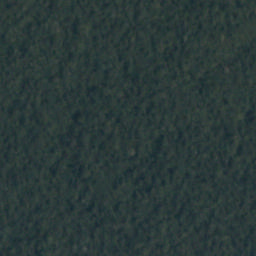

In [16]:
clear_primary = open_image(Train_PATH/'train_2.jpg') 

clear_primary 

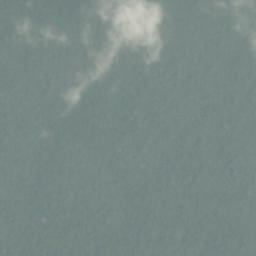

In [17]:
partly_cloudy_primary = open_image(Train_PATH/'train_17.jpg')

partly_cloudy_primary



## Train Model

In [18]:
#Define Transformation 

tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [19]:
src = ImageList.from_df(TrainData,path=Train_PATH,cols='image_name',suffix='.jpg').split_by_rand_pct(0.2).label_from_df(cols='tags',label_delim=' ')

/opt/conda/lib/python3.7/site-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [20]:
 data = src.transform(tfms).databunch(bs=64).normalize(imagenet_stats)

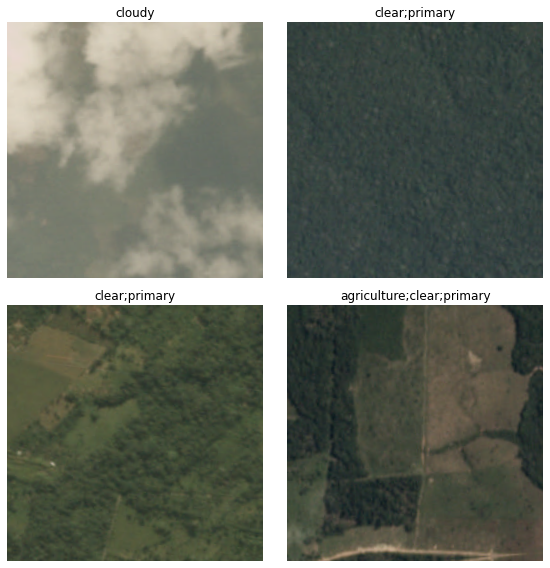

In [21]:
data.show_batch(rows=2)

In [22]:
arch = models.resnet50


In [23]:
acc = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data,arch,metrics=[acc, f_score],model_dir='/kaggle/working')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


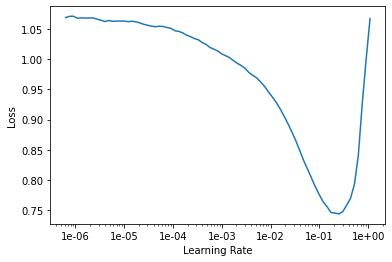

In [24]:
#use LR finder to get a good  a learning rate 

learn.lr_find()
learn.recorder.plot()

In [26]:
# fit the head of the network 

lr = 1e-2

In [27]:
learn.fit_one_cycle(8, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.140581,0.115168,0.942179,0.894893,05:24
1,0.114702,0.101423,0.947833,0.906948,04:48
2,0.105400,0.092583,0.957069,0.916626,04:46
3,0.100310,0.090450,0.953065,0.917848,04:47
4,0.093479,0.087230,0.961254,0.920921,04:46
5,0.088521,0.083507,0.957810,0.926780,04:52
6,0.088061,0.082675,0.958457,0.927865,04:58
7,0.084584,0.082154,0.958529,0.927468,04:52


In [28]:
learn.save('Stage1-rs50-256')

In [29]:
#fine tune the model 

learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


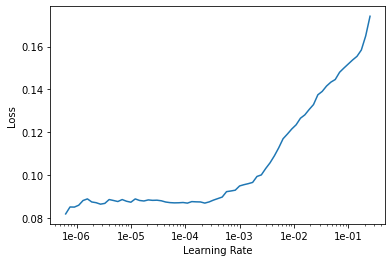

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(8,slice(1e-5,lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.088700,0.085514,0.955550,0.924681,05:26
1,0.093627,0.091361,0.956059,0.919249,05:23
2,0.092741,0.085874,0.957534,0.924711,05:18
3,0.086662,0.083447,0.959481,0.926987,05:16
4,0.084091,0.081860,0.960535,0.928426,05:23
5,0.081158,0.079941,0.960092,0.929613,05:24
6,0.078717,0.078588,0.959525,0.930550,05:22
7,0.075369,0.078996,0.959873,0.930608,05:19


In [32]:
learn.save('Stage2-rs50-256')


In [33]:
learn.export('/kaggle/working/export.pkl')

In [34]:
test = ImageList.from_folder(PATH/'test-jpg').add(ImageList.from_folder('../input/planets-dataset/test-jpg-additional/test-jpg-additional'))
len(test)

61191

In [35]:
learn = load_learner(Path('/kaggle/working'), test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [36]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [37]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [38]:
preds_df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [39]:
preds_df.to_csv('/kaggle/working/submission.csv', index=False)

In [40]:
preds_df.sort_values('image_name', ascending = True).head(10)


,image_name,tags
44419,file_0,clear primary
59851,file_1,agriculture cultivation habitation partly_clou...
44516,file_10,agriculture haze primary road water
54974,file_100,clear primary water
48748,file_1000,agriculture clear primary
58290,file_10000,clear primary
56310,file_10001,agriculture clear primary water
40940,file_10002,agriculture clear habitation primary road
45515,file_10003,agriculture clear cultivation primary
41734,file_10004,partly_cloudy primary


In [41]:
preds_df.shape

(61191, 2)